In [1]:
from sklearn.manifold import TSNE
from collections import Counter
from six.moves import cPickle
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import io
import re
import json
import pickle
import pandas as pd
import gensim

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk

In [2]:
[lib,con,neutral]= pickle.load(open('ibcData.pkl','rb'))

In [3]:
liberal = []
for tree in lib:
    liberal.append(tree.get_words())
conservative = []
for tree in con:
    conservative.append(tree.get_words())
neu = []
for tree in neutral:
    neu.append(tree.get_words())

In [4]:
liberals = pd.DataFrame(liberal,columns=['text'])
liberals['label'] = 0
conservatives = pd.DataFrame(conservative,columns=['text'])
conservatives['label'] = 1
neutrals = pd.DataFrame(neu,columns=['text'])
neutrals['label'] = 2

In [5]:
frames = [liberals,conservatives]
result = pd.concat(frames)
result = result.sample(frac=1).reset_index(drop=True)

## Preprocess the dataset

In [6]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
#     text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
result['text'] = result['text'].apply(clean_text)

In [7]:
X = result.text
y = result.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [8]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3726 entries, 0 to 3725
Data columns (total 2 columns):
text     3726 non-null object
label    3726 non-null int64
dtypes: int64(1), object(1)
memory usage: 58.3+ KB


In [9]:
result.label.value_counts()

0    2025
1    1701
Name: label, dtype: int64

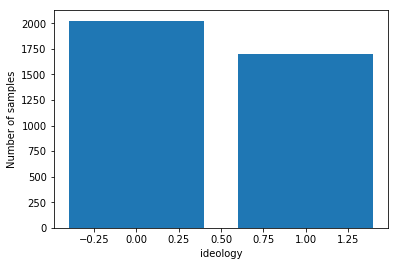

In [10]:
ideology_count=result.groupby('label').count()
plt.bar(ideology_count.index.values, ideology_count['text'])
plt.xlabel('ideology')
plt.ylabel('Number of samples')
plt.show()

## Multinomial naive bayes

In [11]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.6270125223613596


## Linear SVM

In [12]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.6162790697674418


## Logistic Regression

In [13]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.5787119856887298


# Word2vec and Logistic Regression

In [14]:
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [38]:
#  BOW based approaches that includes averaging, summation, weighted addition. 
# The common way is to average the two word vectors


def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, text) for text in text_list ])

In [39]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens


In [40]:
train, test = train_test_split(result, test_size=0.3, random_state = 42)

In [41]:
test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['text']), axis=1).values

In [42]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

/home/avanti/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  if sys.path[0] == '':


In [44]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['label'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.label))

accuracy 0.6100178890876565


In [45]:
# applying the word averaging to linear SVM
svm = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=50, tol=None)
svm = svm.fit(X_train_word_average, train['label'])
y_pred = svm.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.label))

accuracy 0.6216457960644007


### Bag of words feature generation

In [28]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(result['text'])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(text_counts, result['label'], test_size=0.3, random_state=1)


### Multinomial naive bayes classifier

In [30]:
clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)
print("MultinomialNB Accuracy:",accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.6216457960644007


In [31]:
clf = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(X_train,y_train)
predicted = clf.predict(X_test)
print("Linear SVM Accuracy:",accuracy_score(y_test, predicted))

Linear SVM Accuracy: 0.5992844364937389


In [32]:
clf = LogisticRegression(n_jobs=1, C=1e5).fit(X_train,y_train)
predicted = clf.predict(X_test)
print("Logistic Regression Accuracy:",accuracy_score(y_test, predicted))

Logistic Regression Accuracy: 0.5876565295169947


### Feature Generation using TF-IDF

In [33]:
tf = TfidfVectorizer()
text_tf = tf.fit_transform(result['text'])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(text_tf, result['label'], test_size=0.3, random_state=123)

In [35]:
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.6091234347048301


In [36]:
clf = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(X_train,y_train)
predicted = clf.predict(X_test)
print("Linear SVM Accuracy:",accuracy_score(y_test, predicted))

Linear SVM Accuracy: 0.6144901610017889


In [37]:
clf = LogisticRegression(n_jobs=1, C=1e5).fit(X_train,y_train)
predicted = clf.predict(X_test)
print("Logistic Regression Accuracy:",accuracy_score(y_test, predicted))

Logistic Regression Accuracy: 0.5822898032200358
